# Cad: Usd Exchange Rate Prediction (Based on data from 2007-2018)

for TRY Conference (2018) 
by Josephine Choi and Lei Jin 


## Background

This Jupyter  Notebook is created based on webposts by Illiya Valchanov / Rohit Garg 

Illiya Valchanov 
https://datascienceplus.com/how-to-apply-monte-carlo-simulation-to-forecast-stock-prices-using-python/ (Dec 2017) 

Rohit Garg 
https://analyticsindiamag.com/a-primer-to-monte-carlo-simulation-in-python/ (Mar 2018)

The original code is for building a monte carlo simulation model for stock pricing 

The following YouTube video are helpful in understanding monte carlo simulation 

Understanding and creating Monte Carlo Simulation Step by Step 
https://www.youtube.com/watch?v=3gcLRU24-w0



In [250]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import numpy as np
from scipy.stats import norm

## Step 1: Loading the data into Python

- Daily exchange rate data can be found through Bank of Canada website
- As part of the preprocessing, files were downloaded yearly and need to be combined
- Data might be also available through REST API (e.g. quandl) 



In [251]:
Ex2012 = pd.read_excel("data/Ex2012.xlsx",parse_dates=True,index_col=0)
Ex2013 = pd.read_csv("data/Ex2013.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2014 = pd.read_csv("data/Ex2014.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2015 = pd.read_csv("data/Ex2015.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2016 = pd.read_csv("data/Ex2016.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2017 = pd.read_csv("data/Ex2017.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2018 = pd.read_csv("data/Ex2018-05-28.csv",sep="\t",skiprows=8,parse_dates=True,index_col=0)

Ex2011 = pd.read_csv("data/Ex2011.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2010 = pd.read_csv("data/Ex2010.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2009 = pd.read_csv("data/Ex2009.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2008 = pd.read_csv("data/Ex2008.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2007 = pd.read_csv("data/Ex2007.csv",skiprows=8,parse_dates=True,index_col=0)


#Ex2018.head()
Ex2018.drop('Unnamed: 2',axis=1, inplace=True)

Ex2018.column=["IEXE0101"]
Ex2018.head(10)
Ex = Ex2007.append(Ex2008).append(Ex2009).append(Ex2010).append(Ex2011).append(Ex2012).append(Ex2013).append(Ex2014).append(Ex2015).append(Ex2016).append(Ex2017)
#Ex.head()
Ex.column=["IEXE0101"]
Ex.append(Ex2018)
Ex.sample(5)


,IEXE0101
date,
2009-04-24 00:00:00,1.2093
2009-11-04 00:00:00,1.0647
2015-11-19,1.3267
2016-09-01,1.3107
2012-11-07 00:00:00,0.9972


In [252]:
Ex2018.sample(5)

,IEXE0101
date,
2018-05-16,1.2809
2018-04-19,1.2633
2018-01-26,1.2321
2018-05-10,1.2775
2018-01-12,1.2504



## Step 2: Inspect the data and Cleaning the data for model

- Unlike spreadsheet tools like Excel, data inspection through statistics tools (e.g. R) or programming language (e.g. Python) do not rely on visual inspection
- Here are some of the commands that are useful for inspecting data in python 
  * df.describe()
  * df.sample()
  * df.info()
- Remove erroneous data 
- Missing data can be filled with a) mean b) mode c) backfilling or forward filling 
- Make sure the data types were set up correctly
- Inspect the data again before moving forward to the next stage 


In [253]:
Ex.sample(20)

,IEXE0101
date,
2010-08-25 00:00:00,1.0642
2015-04-24,1.2166
2015-07-29,1.2893
2007-05-08 00:00:00,1.1048
2010-11-08 00:00:00,1.0022
2016-11-07,1.3383
2012-12-12 00:00:00,0.9854
2010-04-20 00:00:00,0.9986
2015-03-25,1.2513


In [254]:
Ex.describe()
Ex.sample(20)
Ex['date']=Ex.index.values


#Don't know whether these were coming from 

Ex=Ex[Ex.date!='ERROR']
Ex=Ex[Ex.date!='date']
Ex=Ex[Ex.IEXE0101 != -64]
Ex=Ex[Ex.IEXE0101 != '-64']
Ex=Ex[Ex.date!="ERRORS"]

# Opted to fill the bank holiday (empty fields) with forward filling (ffill). Back filling should do the trick as well 
Ex.IEXE0101=Ex['IEXE0101'].fillna(method="ffill")
Ex["IEXE0101"]=Ex["IEXE0101"].fillna(1)

#Set the type to the correct type 
Ex['IEXE0101'] = Ex['IEXE0101'].astype('float')

Ex['date'] = Ex['date'].astype('datetime64[ns]')

#for some strange reason, there were dates >2019, and thus needs to be removed

Ex=Ex[Ex.date<'2019-01-01']
#Ex.date = Ex.date.apply(pd.to_datetime, format='%d/%m/%Y')
Ex.sort_values(by=['date'])
Ex.set_index(Ex.date,inplace=True)


Ex=Ex.drop('date', axis=1)
#Ex.index=Ex['date']



In [255]:
Ex.info()

print("-"*40)

Ex.describe()
#Ex.drop('date',axis=1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2725 entries, 2007-05-01 to 2017-12-29
Data columns (total 1 columns):
IEXE0101    2725 non-null float64
dtypes: float64(1)
memory usage: 42.6 KB
----------------------------------------


,IEXE0101
count,2725.000000
mean,1.120832
std,0.129969
min,0.917000
25%,1.014800
50%,1.064200
75%,1.250800
max,1.458900


## Step 3: Building the financial model

- Inspect the general trend of existing data 
- We see gradual growth over the past five years
- Five years of past data may not be enough: Model may be biased because of the past performance 


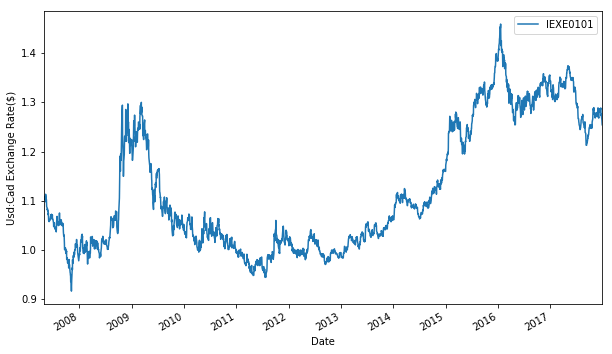

In [256]:

log_returns = np.log(1 + Ex['IEXE0101'].pct_change())
log_returns.tail()

type(log_returns)

Ex.plot(figsize=(10,6))
plt.ylabel("Usd:Cad Exchange Rate($)")
plt.xlabel("Date")
plt.show();


- Plotting the log returns

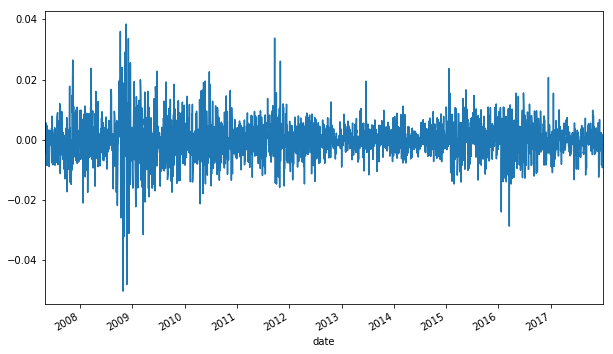

In [257]:
log_returns.plot(figsize=(10,6));

### Finding out the variables required for the calculation of Brownian motion 
- Brownian motion : the formula was first used to model random movement in physics. But has been used to predict the movement of an asset in finance  
- Brownian motion assumes two part of the random movement
  * drift(a constant driving force)
  * random stochastic component(random component) 
- We need 
  * mean 
  * variance (historical volatility) 


In [258]:
u=log_returns.mean()
u
type(u)

float

In [259]:
var=log_returns.var()
var

4.082585340445791e-05

- Brownian motion assumes two parts of movement 
- Drift is the expected rate of return 
- Today's price = Yesterday's price * e ** r
- For standard Monte Carlo : average of historical return - (variance/2) 
- There are other theories are what the drift would be 
 * risk free rate - (variance/2)
 * 0 (supported by random walk theory) 
 



In [260]:
drift=u-(0.5*var)
drift

2.4876557088999917e-05

In [261]:
stdev = log_returns.std()
stdev

0.006389511202311011

In [262]:
#type(drift)
#type(stdev)

In [263]:
drift=np.array(drift)
#type(drift)

In [264]:
#stdev=np.array(stdev)
#type(stdev)
#drift.values
#stdev.values
#norm.ppf(0.95)

For the random component, we need to randomize. This can be done by numpy "rand" function. As an example, the following code will create a multidimensional array


In [265]:
x=np.random.rand(10,2)
x
norm.ppf(x)

array([[ 0.1035365 , -0.25437618],
       [ 1.11606972, -1.1612118 ],
       [ 1.86707153, -0.59002333],
       [-0.13708558,  0.95476801],
       [-0.29107583,  1.22030761],
       [-1.05837867, -0.03428434],
       [-1.28702509, -2.12038311],
       [ 0.1102121 ,  0.39980341],
       [ 0.04523663, -0.13099564],
       [-0.24975861,  0.61230803]])

In [266]:
Z=norm.ppf(np.random.rand(10,2))
Z

array([[-1.06975849, -0.1457144 ],
       [-1.13879488, -0.79194729],
       [ 0.04441784,  0.38866645],
       [ 0.46262141, -1.55206535],
       [-1.14067266, -1.07113469],
       [ 0.05431522, -0.04174948],
       [ 0.54628077,  1.95846841],
       [ 1.55361218, -1.12464709],
       [ 0.25661424, -0.56630673],
       [ 0.16323961, -1.06787709]])

The following code set the number of iterations (the number of trials) and t_intervals (the length of projection)  

In [267]:
t_intervals=1000
iterations=500

This is the formula we used to build our model 
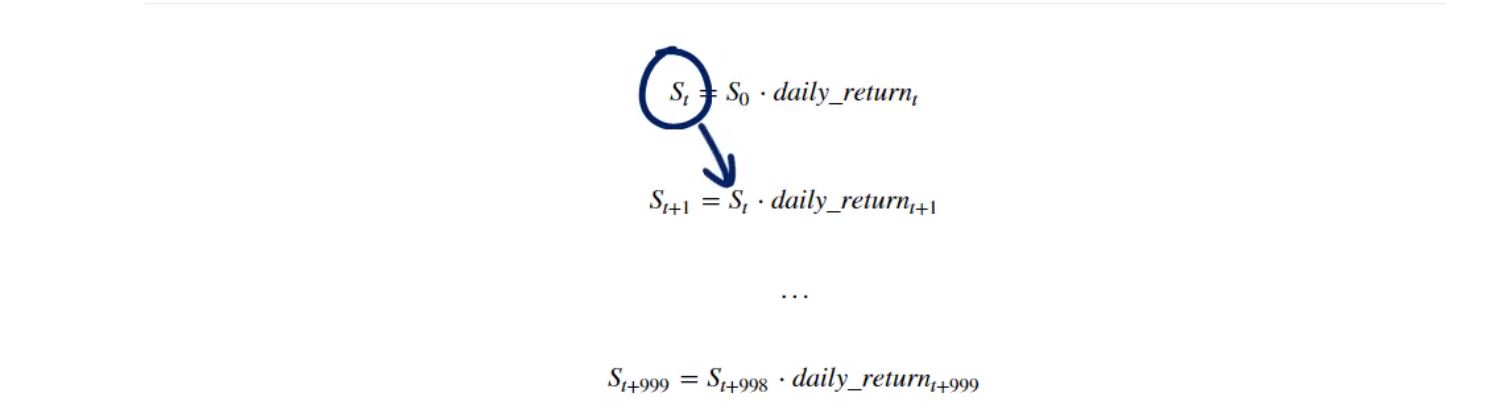

In [268]:
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

In [269]:
type(daily_returns)

numpy.ndarray

In [270]:
S0=Ex.iloc[-1,0]
S0

1.2544999999999999

In [271]:
price_list=np.zeros_like(daily_returns)

In [272]:
price_list

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [273]:
price_list[0]=S0
price_list

array([[ 1.2545,  1.2545,  1.2545, ...,  1.2545,  1.2545,  1.2545],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [274]:
for t in range(1,t_intervals):
    price_list[t]=price_list[t-1]*daily_returns[t]

In [275]:
price_list


array([[ 1.2545    ,  1.2545    ,  1.2545    , ...,  1.2545    ,
         1.2545    ,  1.2545    ],
       [ 1.24731923,  1.26130712,  1.25764475, ...,  1.25065259,
         1.2504504 ,  1.25263732],
       [ 1.23887085,  1.26510738,  1.26519553, ...,  1.26058735,
         1.24605772,  1.2545542 ],
       ..., 
       [ 1.37098379,  1.77360059,  1.07635184, ...,  1.49541572,
         1.83040679,  1.03689177],
       [ 1.37650471,  1.76163885,  1.07940111, ...,  1.49760299,
         1.82971847,  1.04523946],
       [ 1.36474297,  1.76561978,  1.07977964, ...,  1.50515065,
         1.81221542,  1.04446261]])

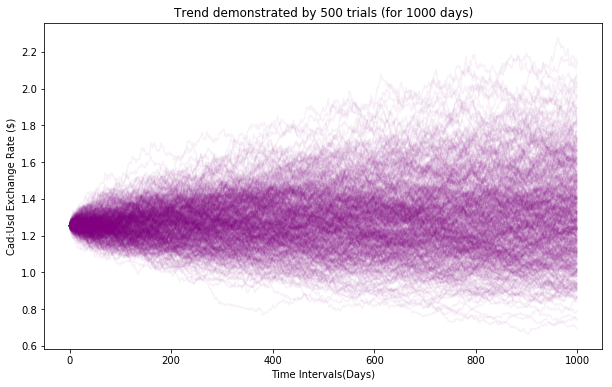

In [276]:
plt.figure(figsize=(10,6));
plt.plot(price_list,color="purple",alpha=0.05);
plt.xlabel("Time Intervals(Days)")
plt.ylabel("Cad:Usd Exchange Rate ($)")
plt.title("Trend demonstrated by 500 trials (for 1000 days)");

In [277]:
price_list.shape

prediction=pd.DataFrame(price_list)
prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,...,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500,1.254500
1,1.247319,1.261307,1.257645,1.272394,1.249725,1.270945,1.264684,1.260530,1.268688,1.254439,...,1.258322,1.240431,1.263639,1.248825,1.260009,1.245819,1.247164,1.250653,1.250450,1.252637
2,1.238871,1.265107,1.265196,1.269626,1.260663,1.271855,1.252030,1.269770,1.253565,1.259378,...,1.264287,1.233247,1.256718,1.267745,1.264008,1.252559,1.261787,1.260587,1.246058,1.254554
3,1.234355,1.266832,1.267851,1.272256,1.253641,1.285109,1.260492,1.273870,1.255972,1.250882,...,1.270463,1.225678,1.250755,1.273890,1.261241,1.253520,1.259424,1.260910,1.246996,1.253916
4,1.240089,1.264581,1.269279,1.272539,1.242614,1.259385,1.269748,1.258085,1.260465,1.246459,...,1.271768,1.217663,1.254225,1.289996,1.268916,1.259505,1.267629,1.245098,1.252397,1.251695


## Step 4: Analysis 

 - The Monte Carlo simulation allows us to speculate the foreign exchange rate based on a selected timeframe. 
 - It is different from a regular projection because we can now quantify probability. This was made possible by central limit theorum 
 

### Central Limit Theorum 
- if we graph enough periodical daily returns of an asset, the graph should form a normal distribution, bell shaped graph

TP = YS * e ** r
TP = Tomorrow's stock price 
S = Today's stock price 
r = periodical daily rate of return


## Prediction

### 3 Months from start date (Aug 28th 2018)

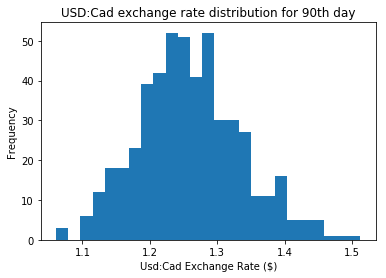

The mean for 90th day distribution is 1.259168
Probability of exchange rate over 1.4 after 90 days: 4 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.259168
std        0.076166
min        1.060925
25%        1.207042
50%        1.254589
75%        1.306765
max        1.512344
Name: 90, dtype: float64

In [278]:
pred90=prediction.iloc[90,:]
mean90=pred90.mean()

pred1=prediction.iloc[90,:]>1.4
prob=pred1.sum()/500 *100

plt.hist(pred90,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 90th day");
plt.show()



print("The mean for 90th day distribution is %f" %(mean90))
print( "Probability of exchange rate over 1.4 after 90 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[90,:].describe()

### One month from start date 

0.494373148158


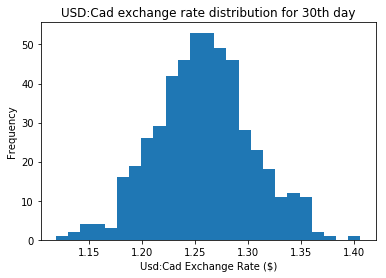

The mean for 30th day distribution is 1.258456
Probability of exchange rate over 1.25 after 30 days: 57 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.258456
std        0.045401
min        1.119058
25%        1.228344
50%        1.257972
75%        1.288293
max        1.406307
Name: 30, dtype: float64

In [279]:
pred30=prediction.iloc[30,:]

mean30=pred30.mean()

pred2=prediction.iloc[30,:]>1.25 
std1=pred2.std()
print(std1)

plt.hist(pred30,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 30th day");
plt.show()


prob=pred2.sum()/500 *100

print("The mean for 30th day distribution is %f" %(mean30))

print( "Probability of exchange rate over 1.25 after 30 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[30,:].describe()

### 6 months from start date 

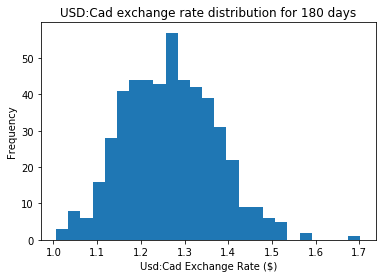

The mean for 180th day distribution is 1.266774
Probability of exchange rate over 1.4 after 180 days: 9 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.266774
std        0.105423
min        1.005841
25%        1.190199
50%        1.264115
75%        1.339105
max        1.702542
Name: 180, dtype: float64

In [280]:
pred180=prediction.iloc[180,:]
mean180=pred180.mean()

pred2=prediction.iloc[180,:]>1.4


plt.hist(pred180,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 180 days");
plt.show()


prob=pred2.sum()/500 *100

print("The mean for 180th day distribution is %f" %(mean180))

print( "Probability of exchange rate over 1.4 after 180 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[180,:].describe()

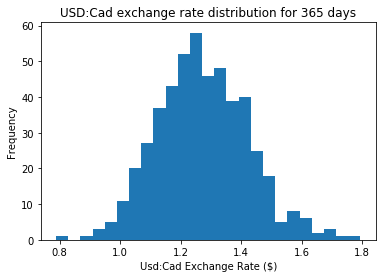

The mean for 365th day distribution is 1.272979
Probability of exchange rate over 1.4 after 365 days: 20 percent
Probability of exchange rate less than 1.31 after 365 days: 60 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.272979
std        0.150422
min        0.788537
25%        1.170539
50%        1.265886
75%        1.373300
max        1.794143
Name: 365, dtype: float64

In [281]:
pred365=prediction.iloc[365,:]

mean365= prediction.iloc[365,:].mean()

pred3=prediction.iloc[365,:]>1.4
pred2=prediction.iloc[365,:]<1.31
prob1 =(pred3.sum()/500) *100
prob2=(pred2.sum()/500)*100

plt.hist(pred365,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 365 days");
plt.show()

print("The mean for 365th day distribution is %f" %(mean365))
print( "Probability of exchange rate over 1.4 after 365 days: %d percent" %(prob1)) 
print( "Probability of exchange rate less than 1.31 after 365 days: %d percent" %(prob2)) 

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[365,:].describe()


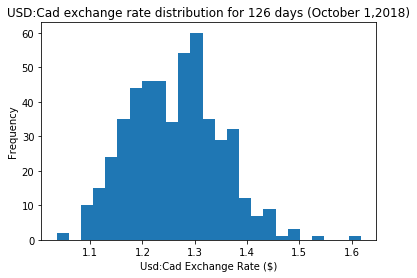

The mean for 126th day distribution is 1.261720
Probability of exchange rate over 1.28 after 126 days: 42 percent
Probability of exchange rate less than 1.275 after 126 days: 54 percent
Probability of exchange rate less than 1.25 after 126 days:45 percent
Probability of exchange rate less than 1.225 after 126 days:36 percent
Probability of exchange rate over 1.3 after 126 days: 34 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.261720
std        0.086489
min        1.035599
25%        1.196780
50%        1.262004
75%        1.321229
max        1.617682
Name: 126, dtype: float64

In [282]:
# October 1,2018 would be 126 days from the start date 

pred126=prediction.iloc[126,:]

mean126= prediction.iloc[126,:].mean()

pred3=prediction.iloc[126,:]>1.28
pred2=prediction.iloc[126,:]<1.275
pred4=prediction.iloc[126,:]<1.25
pred5=prediction.iloc[126,:]<1.225
pred6=prediction.iloc[126,:]>1.3

prob1 =(pred3.sum()/500) *100
prob2=(pred2.sum()/500)*100
prob4=(pred4.sum()/500)*100
prob5=(pred5.sum()/500)*100
prob6=(pred6.sum()/500)*100

plt.hist(pred126,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 126 days (October 1,2018)");
plt.show()

print("The mean for 126th day distribution is %f" %(mean126))
print( "Probability of exchange rate over 1.28 after 126 days: %d percent" %(prob1)) 
print( "Probability of exchange rate less than 1.275 after 126 days: %d percent" %(prob2)) 
print("Probability of exchange rate less than 1.25 after 126 days:%d percent" %(prob4))
print("Probability of exchange rate less than 1.225 after 126 days:%d percent" %(prob5))
print( "Probability of exchange rate over 1.3 after 126 days: %d percent" %(prob6)) 

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[126,:].describe()



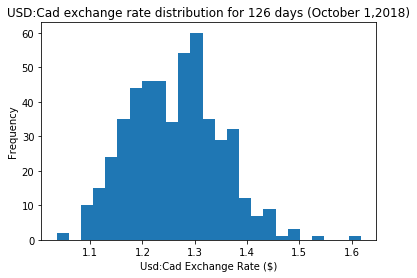

The mean for 126th day distribution is 1.261720
Probability of exchange rate over 1.28 on the 126th day: 42 percent
Probability of exchange rate over 1.3 on the 126th day: 34 percent
From Jun 1, 2018 to October 1, 2018
Probability of exchange rate less than 1.275 during this period: 62 percent
Probability of exchange rate less than 1.25 during this period:45 percent
Probability of exchange rate less than 1.225 during this period:29 percent
----------------------------------------
Prediction details are as follow for the 126th day:


count    500.000000
mean       1.261720
std        0.086489
min        1.035599
25%        1.196780
50%        1.262004
75%        1.321229
max        1.617682
Name: 126, dtype: float64

In [283]:
# October 1,2018 would be 126 days from the start date 

pred126=prediction.iloc[126,:]

mean126= prediction.iloc[126,:].mean()

pred3=prediction.iloc[126,:]>1.28
pred2=prediction.iloc[10:126,:]<1.275
pred4=prediction.iloc[10:126,:]<1.25
pred5=prediction.iloc[10:126,:]<1.225
pred6=prediction.iloc[126,:]>1.3

prob1=(pred3.sum()/(500))*100
prob2=(pred2.sum().sum()/(500*116))*100
prob4=(pred4.sum().sum()/(500*116))*100
prob5=(pred5.sum().sum()/(500*116))*100
prob6=(pred6.sum()/(500))*100




plt.hist(pred126,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 126 days (October 1,2018)");
plt.show()

print("The mean for 126th day distribution is %f" %(mean126))


#print(prob2.mean())
print("Probability of exchange rate over 1.28 on the 126th day: %d percent" %(prob1)) 
print( "Probability of exchange rate over 1.3 on the 126th day: %d percent" %(prob6)) 
print("From Jun 1, 2018 to October 1, 2018")
print("Probability of exchange rate less than 1.275 during this period: %d percent" %(prob2)) 
print("Probability of exchange rate less than 1.25 during this period:%d percent" %(prob4))
print("Probability of exchange rate less than 1.225 during this period:%d percent" %(prob5))


print("-"*40)

print("Prediction details are as follow for the 126th day:")
prediction.iloc[126,:].describe()